In [1]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import airfoil as ar

%matplotlib inline

The purpose of this notebook is to model the motion of a flapping fish in python but in a way that can be directly translated to an Ansys Fluent UDF function

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
#dx = (0.5*(1-np.cos(beta)))
# uniform spacing
dx = np.linspace(0.0, chord, 100)
X, Y = ar.naca4(dx, 0.12, 0.0, 0.30, True, chord)
x, y = ar.convert_to_coordinates(X, Y)

(-0.1, 0.1)

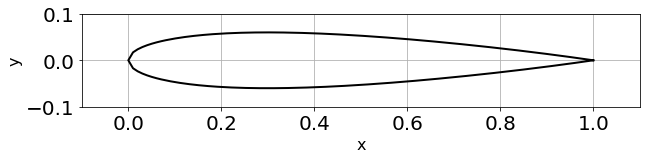

In [3]:
plt.rcParams.update({'font.size':20})

# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

Output airfoil to a file for geometry import

Motion as determined by Anderson.

- Oscillation about the one-third chord
- alpha(t) = -arctan(pi St cos(wt)) + theta(t)

In [4]:
def airfoil_motion(U, St, h0, alpha_0, phi=90, number_cycles=1.5):
    # define frequency from strouhal number
    freq = St*U/(2*h0)
    time = np.linspace(0, number_cycles * (1/freq), 1500)
    omega = 2*np.pi*freq
    # alpha as defined in Anderson et al. 1998
    theta_0 = np.arctan(np.pi*St) - alpha_0
    alpha = np.arctan(np.pi*St*np.cos(omega*time)) - theta_0*np.sin(omega*time + np.deg2rad(phi))
    
    zero_crossings = np.where(np.diff(np.sign(alpha)))[0]
    alpha_cycle = alpha[zero_crossings[0]+1:zero_crossings[-1]+1]
    time_cycle = time[zero_crossings[0]+1:zero_crossings[-1]+1]
    time_cycle = time_cycle - time_cycle[0]

    return time_cycle, alpha_cycle, np.rad2deg(alpha_cycle)

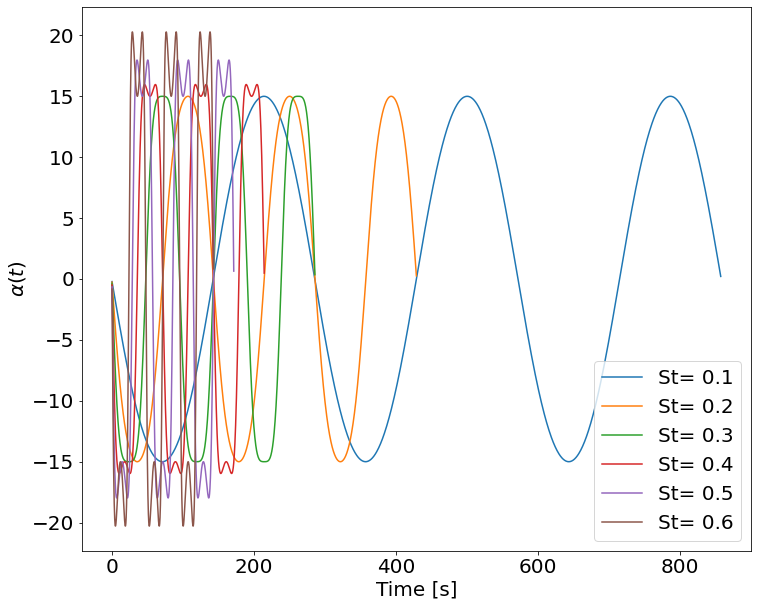

In [5]:
# define the freestream from Reynolds number
Re = 40000
visc = 1.31e-6
chord = 1.0

U = Re*visc/chord

phi = np.deg2rad(90)

h0 = 0.75 * chord

alpha_0 = np.deg2rad(15)

Strouhal = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

fig1, ax1 = plt.subplots(figsize=(12,10))
for St in Strouhal:
    time, alpha_rad, alpha_deg = airfoil_motion(U, St, h0, alpha_0, number_cycles=3.5)
    ax1.plot(time, alpha_deg, label='St= ' + str(St))

ax1.set_xlabel('Time [s]')
ax1.set_ylabel(r'$ \alpha (t) $')
ax1.legend()

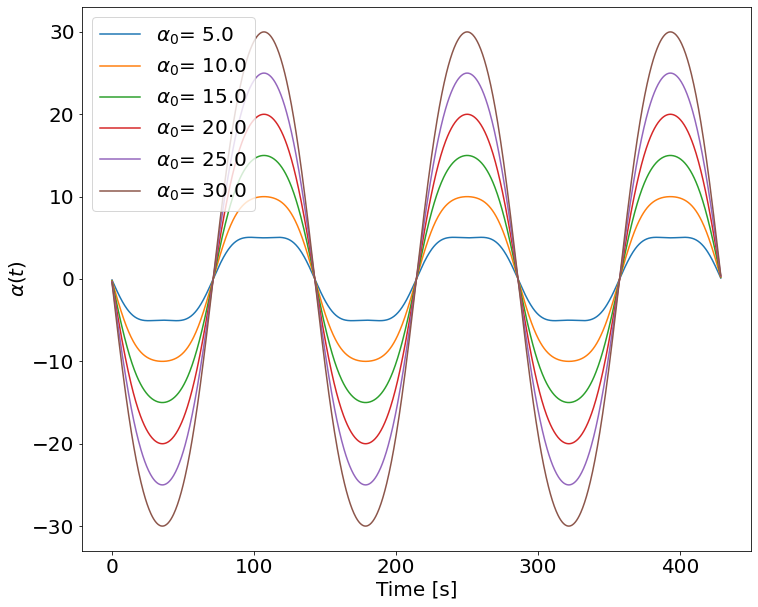

In [6]:
St = 0.2

alpha_0s = np.deg2rad([5, 10, 15, 20, 25, 30])

fig2, ax2 = plt.subplots(figsize=(12,10))
for alpha_0 in alpha_0s:
    time, alpha_rad, alpha_deg = airfoil_motion(U, St, h0, alpha_0, number_cycles=3.5)
    ax2.plot(time, alpha_deg, label=r'$ \alpha_0 $= ' + str(np.round(np.rad2deg(alpha_0),3)))

ax2.set_xlabel('Time [s]')
ax2.set_ylabel(r'$ \alpha (t)$')
ax2.legend()

In [25]:
St = 0.2
alpha_0 = np.deg2rad(30)
time, alpha_rad, alpha_deg = airfoil_motion(U, St, h0, alpha_0, number_cycles=3.5)
number_points = time.shape[0]

In [26]:
txt_template = '({times} (({surge} {sway} {heave}) ({roll} {pitch} {yaw}))) \n'
header = '\n' + str(number_points) + '\n' + '( \n'
footer = ')'

with open('6DoF.dat', 'w') as f:
    f.write(header)
    for i, timestep in enumerate(time):
        f.write(txt_template.format(times=np.round(timestep,4), surge=0.0, sway=0.0, heave=0.0,
                                    roll=0.0, pitch=0.0, yaw=np.round(alpha_deg[i],4)))
    f.write(footer)

In [18]:
print(time[-1])

428.7686702076193
